In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from alpha_vantage.timeseries import TimeSeries
import os

In [62]:
TIME_SERIES = TimeSeries(key=os.environ.get("ALPHA_VANTAGE_KEY"), output_format="pandas", indexing_type="data")
COLUMN_RENAME = {"date": "Date", "1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. adjusted close": "Adj Close", "6. volume": "Volume"}

In [63]:
## STARTED SONN NOT REALLY BUT FOR SELLING PURPOSES: DATE: 2021-08-20 00:00:00 day 60: buy 1000 units at price 631.300000, total balance 231.270000
## STARTED FAMI NOT REALLY BUT FOR SELLING PURPOSES: DATE: 2021-08-27 00:00:00 day 24: buy 1000 units at price 391.300000, total balance 608.700000
TICKER = "CEI"
TICKER

'CEI'

In [64]:
dailyAdjustedRaw = TIME_SERIES.get_daily_adjusted(symbol=TICKER, outputsize="full")[0]
df = dailyAdjustedRaw.sort_values(by="date", ascending=False).reset_index().rename(columns=COLUMN_RENAME).drop(["7. dividend amount", "8. split coefficient"], axis=1, inplace=False)

In [65]:
df = df.head(20).sort_values(by="Date", ascending=True).reset_index().drop(["index"], axis=1, inplace=False)
df.iloc[19:20]

,Date,Open,High,Low,Close,Adj Close,Volume
19,2021-10-01,3.49,3.54,2.86,3.25,3.25,323930920.0


In [66]:
# df = pd.read_csv('../dataset/GOOG-year.csv')
# df.tail()

In [67]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,0.8271,NaN,NaN
1,0.0,0.9726,NaN,NaN
2,-1.0,0.9920,0.9726,0.8271
3,-1.0,1.3000,0.9920,0.9726
4,-1.0,1.5200,1.3000,0.9920
5,0.0,1.3900,1.5200,1.3000
6,-1.0,1.5800,1.5200,1.3900
7,-1.0,1.6400,1.5800,1.3900
8,-1.0,1.7200,1.6400,1.5800
9,0.0,1.6900,1.7200,1.6400


In [68]:
def buy_stock(
    real_movement,
    signal,
    dates,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'DATE: %s day %d: total balances %f, not enough money to buy a unit price %f'
                % (dates[i], i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'DATE: %s day %d: buy %d units at price %f, total balance %f'
                % (dates[i], i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('DATE: %s day %d: cannot sell anything, inventory 0' % (dates[i], i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'DATE: %s day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (dates[i], i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [69]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'], df.Date, initial_money=1000, max_buy=1000, max_sell=1000)

DATE: 2021-09-08 00:00:00 day 2: cannot sell anything, inventory 0
DATE: 2021-09-09 00:00:00 day 3: cannot sell anything, inventory 0
DATE: 2021-09-10 00:00:00 day 4: cannot sell anything, inventory 0
DATE: 2021-09-14 00:00:00 day 6: cannot sell anything, inventory 0
DATE: 2021-09-15 00:00:00 day 7: cannot sell anything, inventory 0
DATE: 2021-09-16 00:00:00 day 8: cannot sell anything, inventory 0
DATE: 2021-09-20 00:00:00 day 10: buy 645 units at price 999.750000, total balance 0.250000
DATE: 2021-09-22 00:00:00 day 12: total balances 0.250000, not enough money to buy a unit price 1.460000
DATE: 2021-09-23 00:00:00 day 13, sell 645 units at price 1225.500000, investment 30.136986 %, total balance 1225.750000,
DATE: 2021-09-24 00:00:00 day 14: cannot sell anything, inventory 0
DATE: 2021-09-27 00:00:00 day 15: cannot sell anything, inventory 0
DATE: 2021-09-28 00:00:00 day 16: cannot sell anything, inventory 0
DATE: 2021-09-29 00:00:00 day 17: cannot sell anything, inventory 0
DATE: 2

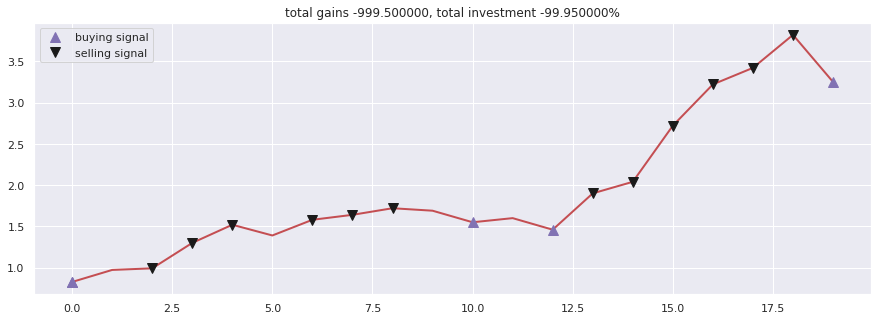

In [70]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()